In [236]:
import pandas as pd
import numpy as np
import pickle as pkl
import math
import gradio as gr
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Resizing

In [3]:
tf.__version__

'2.10.0'

In [237]:
# Read data 
df = pd.read_csv('captions.txt')

In [238]:
def preprocess_text(text):
    text = 'startseq ' + text + ' endseq'
    return text

In [239]:
# Adding start and end token
df['caption'] = df['caption'].apply(preprocess_text)

In [240]:
# Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['caption'])

In [241]:
# Vocabulary Size
vocab_size = len(tokenizer.word_index) + 1

In [242]:
# Max len caption
max_len = max(len(i) for i in tokenizer.texts_to_sequences(df['caption']))

39

In [243]:
# Join all different list of caption into one
df = df.groupby('image',as_index=False).aggregate({'caption':list})

In [246]:
df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg   

                                             caption  
0  [startseq A child in a pink dress is climbing ...  
1  [startseq A black dog and a spotted dog are fi...  
2  [startseq A little girl covered in paint sits ...  
3  [startseq A man lays on a bench while his dog ...  
4  [startseq A man in an orange hat starring at s...

In [247]:
df['caption']

0       [startseq A child in a pink dress is climbing ...
1       [startseq A black dog and a spotted dog are fi...
2       [startseq A little girl covered in paint sits ...
3       [startseq A man lays on a bench while his dog ...
4       [startseq A man in an orange hat starring at s...
                              ...                        
8086    [startseq A man does a wheelie on his bicycle ...
8087    [startseq A group is sitting around a snowy cr...
8088    [startseq A grey bird stands majestically on a...
8089    [startseq A person stands near golden walls . ...
8090    [startseq A man in a pink shirt climbs a rock ...
Name: caption, Length: 8091, dtype: object

In [248]:
# Train Test Split
train_data = df.iloc[:6500]
test = df.iloc[6500:]

In [253]:
# Image Feauture extraction model
vgg_model = VGG16()
vgg_model.trainable = False
img_model = Model(inputs = vgg_model.input,outputs=vgg_model.layers[-2].output)

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [127]:
target_shape = (224, 224)
batch_size = 32

In [128]:
# Load all image preprocess it and Extract feature from image
image_features = {}
base_dir = 'Images/'

for image in tqdm(df['image']):
    img_path = base_dir + image
    img = load_img(img_path,
                     target_size=target_shape)
    img = img_to_array(img)
    img = tf.expand_dims(img,axis=0)
    img = preprocess_input(img)

    feature = vgg_model.predict(img,verbose=False)
    image_features[image] = feature



In [129]:
# with open('img_features.pkl','wb') as f:
#     pkl.dump(image_features,f)

In [130]:
# pickling the image feature dict
with open('img_features.pkl','rb') as f:
    img_features = pkl.load(f)

In [131]:
# Custome Data genarator for seq-to-seq Modeling
class data_genarator(Sequence):

    def __init__(self,data,img_features,tokenizer,batch_size=32):
        self.data = data
        self.img_features = img_features
        self.tokenizer = tokenizer
        self.batch_size = batch_size

    def __len__(self):
        # Returns the number of batches
        return len(self.data) // self.batch_size
    
    def __getitem__(self,index):
        # Return each batch of data
        batch_data = self.data.iloc[index * self.batch_size : (index+1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch_data)
        return [X1, X2], y
    
    def __get_data(self,batch_data):
        # Genarate Sequntial data 
        X1 , X2, y = list(), list(), list()

        for image_id in batch_data['image']:
            img_vector = self.img_features[image_id][0]
            captions = batch_data[batch_data['image']==image_id]['caption'].values[0]
            
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):

                    input_seq = seq[:i]
                    output_seq = seq[i]
                    input_seq = pad_sequences([input_seq],
                                                maxlen=30,
                                                padding='post')[0]
                    
                    output_seq = to_categorical([output_seq],
                                                num_classes=vocab_size)[0]

                    X1.append(img_vector)
                    X2.append(input_seq)
                    y.append(output_seq)
                    
        X1, X2, y = np.array(X1),np.array(X2),np.array(y)
        return X1, X2, y



                        

                        

                   

                        




        

In [132]:
# class CustomDataGenerator(Sequence):
    
#     def __init__(self, df, X_col, y_col, batch_size, tokenizer, 
#                  vocab_size, max_length, features,shuffle=True):
    
#         self.df = df.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.tokenizer = tokenizer
#         self.vocab_size = vocab_size
#         self.max_length = max_length
#         self.features = features
#         self.shuffle = shuffle
#         self.n = len(self.df)
        
#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df = self.df.sample(frac=1).reset_index(drop=True)
    
#     def __len__(self):
#         return self.n // self.batch_size
    
#     def __getitem__(self,index):
    
#         batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
#         X1, X2, y = self.__get_data(batch)        
#         return (X1, X2), y
    
#     def __get_data(self,batch): 
        
#         X1, X2, y = list(), list(), list()
#         images = batch[self.X_col].tolist()
           
#         for image in images:
#             feature = self.features[image][0]
#             captions = batch.loc[batch[self.X_col]==image, self.y_col].values[0]

#             for caption in captions:
#                 seq = self.tokenizer.texts_to_sequences([caption])[0]

#                 for i in range(1,len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     in_seq = pad_sequences([in_seq], maxlen=self.max_length,padding='post')[0]
#                     out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
#                     X1.append(feature)
#                     X2.append(in_seq)
#                     y.append(out_seq)
            
#         X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
#         return X1, X2, y

In [135]:
# Model Building

input_1 = layers.Input(shape=(1000,))
fc1  = layers.Dense(512,activation='relu')(input_1)

input_2 = layers.Input(shape=(30,))
embedding = layers.Embedding(vocab_size,512,mask_zero=True)(input_2)

add = layers.add([fc1,embedding])

lstm  = layers.LSTM(128)(add)
fc2 = layers.Dense(256, activation='relu')(lstm)
softmax = layers.Dense(vocab_size,activation='softmax')(fc2)


model = Model(inputs=[input_1,input_2],
              outputs=softmax )

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [136]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense_9 (Dense)                (None, 512)          512512      ['input_7[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 30, 512)      4349952     ['input_8[0][0]']                
                                                                                            

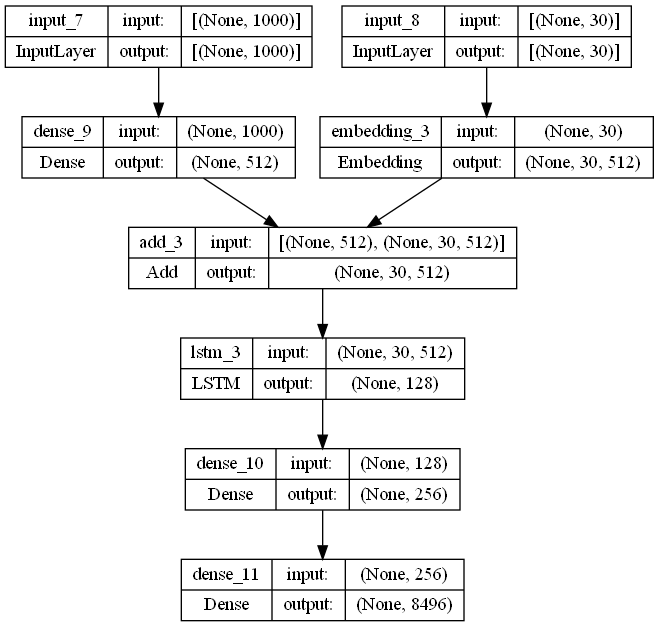

In [137]:
plot_model(model,show_shapes=True)

In [138]:
train_ds = data_genarator(data=train_data,img_features=img_features,tokenizer=tokenizer)

test_ds = data_genarator(data=test,img_features=img_features,tokenizer=tokenizer)

In [139]:
train_ds[0][0][1].shape

(1998, 30)

In [140]:
# train_generator = CustomDataGenerator(df=train_data,
#                                       X_col='image',
#                                       y_col='caption',
#                                       batch_size=32,
#                                       tokenizer=tokenizer,
#                                       vocab_size=vocab_size,
#                                       max_length=30,
#                                       features=img_features)

In [ ]:
model.fit(train_ds,
          epochs=15,
          validation_data=test_ds)

Epoch 1/20
203/203 [==============================] - 40s 176ms/step - loss: 4.9081 - val_loss: 4.1670
Epoch 2/20
203/203 [==============================] - 34s 166ms/step - loss: 3.9464 - val_loss: 3.7417
Epoch 3/20
203/203 [==============================] - 33s 161ms/step - loss: 3.6003 - val_loss: 3.5350
Epoch 4/20
203/203 [==============================] - 32s 155ms/step - loss: 3.3984 - val_loss: 3.4103
Epoch 5/20
203/203 [==============================] - 32s 158ms/step - loss: 3.2561 - val_loss: 3.3249
Epoch 6/20
203/203 [==============================] - 34s 166ms/step - loss: 3.1435 - val_loss: 3.2565
Epoch 7/20
203/203 [==============================] - 35s 170ms/step - loss: 3.0519 - val_loss: 3.2185
Epoch 8/20
203/203 [==============================] - 35s 172ms/step - loss: 2.9731 - val_loss: 3.1798
Epoch 9/20
203/203 [==============================] - 401s 2s/step - loss: 2.9064 - val_loss: 3.1590
Epoch 10/20
203/203 [==============================] - 18453s 91s/step - lo

KeyboardInterrupt: 

In [254]:
# model.save('caption_genaration_model.h5')

In [177]:
def index_to_word(word_idx):
    return tokenizer.index_word[word_idx]

In [192]:
def predict_next(img):

    seq_in = 'startseq'
    feature_img = img_features[img]

    for i in range(30):
        seq_in_sequence = tokenizer.texts_to_sequences([seq_in])[0]
        seq_in_padded = pad_sequences([seq_in_sequence], padding='post',maxlen=30)
        y_hat = model.predict([feature_img,seq_in_padded],verbose=False)
        word_index = y_hat.argmax(axis=1)
        predicted_word = index_to_word(word_index[0])

        if predicted_word == 'endseq':
            break
        seq_in = seq_in + ' ' + predicted_word 

    return seq_in


In [193]:
predict_next('990890291_afc72be141.jpg')

'startseq a man in a black helmet and a black helmet riding a bike'

#### Caption Genaration

In [230]:
resize_img = Resizing(height=224, width=224)

def img_preprocces(img): 
    # preprocces image & Extract feature
    img = tf.expand_dims(img,axis=0)
    resized_image = resize_img(img)
    img = preprocess_input(resized_image)
    feature = vgg_model.predict(img,verbose=False)

    return feature

In [231]:

def genarate_caption(img):

    seq_in = 'startseq'
    feature_img = img_preprocces(img)
    
    for i in range(30):
        seq_in_sequence = tokenizer.texts_to_sequences([seq_in])[0]
        seq_in_padded = pad_sequences([seq_in_sequence], padding='post',maxlen=30)
        y_hat = model.predict([feature_img,seq_in_padded],verbose=False)
        word_index = y_hat.argmax(axis=1)
        predicted_word = index_to_word(word_index[0])
        seq_in = seq_in + ' ' + predicted_word 
        if predicted_word == 'endseq':
            break
    
    return seq_in

In [232]:
predict_next('img.jpg')

UnimplementedError: Exception encountered when calling layer "resizing_2" "                 f"(type Resizing).

{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to float is not supported [Op:Cast]

Call arguments received by layer "resizing_2" "                 f"(type Resizing):
  • inputs=tf.Tensor(shape=(1,), dtype=string)

In [234]:
# Demo modeling

demo = gr.Interface(
    fn=genarate_caption,
    inputs=['image'],
    outputs=['text']
)

In [235]:
demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\VICTUS\anaconda3\envs\GPU\lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 401, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "c:\Users\VICTUS\anaconda3\envs\GPU\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "c:\Users\VICTUS\anaconda3\envs\GPU\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\VICTUS\anaconda3\envs\GPU\lib\site-packages\starlette\applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\VICTUS\anaconda3\envs\GPU\lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "c:\Users\VICTUS\anaconda3\envs\GPU\lib\site-packages\starlette\middleware\errors.py", line 165, in __call__
 

In [255]:
with open('tokenizer.pkl','wb') as f:
    pkl.dump(tokenizer,f)

In [ ]:
tf.__version__

NameError: name 'tf' is not defined